In [30]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math
from pyparsing import python_style_comment
from itertools import islice

In [31]:
def compute_N(n):
  def agen(): # generator of terms
      aset, sset, k = set(), set(), 0
      while True:
          k += 1
          while any(k+an in sset for an in aset): k += 1
          yield k; sset.update(k+an for an in aset); aset.add(k)
  a = list(islice(agen(), 100))
  photon = list(map(lambda v: v-1, a))
  compute_N= [sum(photon[:i]) for i in range(1,len(photon)+1)]
  return compute_N[n]

#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
def combination(n, r):
    # if r > n:
    #     return 0
    # else:
    return math.factorial((int(n))) / (math.factorial((int(n-r))) * math.factorial((int(r))))

# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution

def Loss_Distribute(n, P_l, l):
    # if P_l == 0:
    #     return 1
    # else:
      return combination(n, l) * (P_l)**l * (1 - P_l)**(n - l)

def Add_Distribute(n, P_a, a):
    N_n = compute_N(n)
    # if P_a == 0:
    #     return 1
    # else:
    return combination(N_n - n, a) * (P_a)**a * (1 - P_a)**(N_n - n - a)

# define a separate function for computing the probability of error
def P_err(n, P_l, P_a,l,a):
  return Loss_Distribute(n,P_l,l) * Add_Distribute(n,P_a, a)
  #return combination(n,l) * (P_l)**l*(1-P_l)**(n-l) * combination(N-n,a) * (P_a)**a*(1-P_a)**(N-n-a) 

# We put these into P_D for re-normalization, These are the probability of error we can correct
# define separate functions for computing the probability of success
def P_Success0(n,P_l,P_a,l,a):
  return P_err(n,P_l, P_a,0,0)

def P_Success1(n,P_l,P_a,l,a):
  P0 = P_Success0(n, P_l, P_a,l,a)
  P1 = P_err(n, P_l, P_a, l=0, a=1) + P_err(n, P_l, P_a, l=1, a=0)
  return P0 + P1

def P_Success2(n,P_l,P_a,l,a):
  P1 = P_Success1(n, P_l, P_a)
  P2 = P_err(n, P_l, P_a, l=1, a=1) + P_err(n, P_l, P_a, l=2, a=0) + P_err(n, P_l, P_a, l=0, a=2)
  return P1 + P2

def P_Success3(n,P_l,P_a,l,a):
  P2 = P_err(n, P_l, P_a, l=1, a=1) + P_err(n, P_l, P_a, l=2, a=0) + P_err(n, P_l, P_a, l=0, a=2)
  P3 = P_err(n, P_l, P_a,1,2) + P_err(n, P_l, P_a, 2,1) + P_err(n, P_l, P_a,3,0) + P_err(n, P_l, P_a,0,3)
  return P2 + P3

def P_D(n,P_l,P_a, l=0,a=0):
  
# we only consider at most 1 error, i.e. P_0 + P_1
  return 1 - P_Success1(n,P_l,P_a,l,a)

def P_AB(n, P, P_D):
    # Calculates the sum and use it to set the diagonal elements, 
    # which returns the distribution sum.
    def binomial_distribution(P, n):
        distribution = [((1-P) ** r) * ((P) ** (n -1 - r)) for r in range(n+1)]
        # we do not calcualte the last term, becasue 
        distribution_sum = sum(distribution[:-1])
        return distribution_sum
    # Generates all permutations of length n.
    permutations = itertools.permutations(range(n))
    num_permutations = len(list(permutations))
    # Creates an n! x n! matrix with diagonal elements set to the distribution sum.
    distribution_sum = binomial_distribution(P, n)
    # then we put it to the diagonal elements
    # n! x n!
    # matrix = [[ 1/(1-P_D) * (1/num_permutations) * distribution_sum if i == j else 0 for j in range(num_permutations)] for i in range(num_permutations)]
    # matrix = [[ 1/(1-P_D) * (1/num_permutations) if i == j else 0 for j in range(num_permutations)] for i in range(num_permutations)]
    # matrix = [[ (1/num_permutations) * distribution_sum if i == j else 0 for j in range(num_permutations)] for i in range(num_permutations)]
    matrix = (1/math.factorial(n)) * (1-P_D) * np.eye(math.factorial(n)) #if i == j else 0 for j in range(math.factorial(n))] for i in range(math.factorial(n))]
    return matrix

# sum over the elements in rows in the probability matrix P_AB
# renormalized in P_AB already
def P_A(P_AB, P_D):
    if P_D == 1:
        return [1 for row in P_AB]
    else:
        return [1/(1-P_D) * sum(row) for row in P_AB] 
# sum over the elements in columns in the probability matrix P_AB
# renormalized in P_AB already
def P_B(P_AB, P_D):
    if P_D == 1:
        return [1 for col in zip(*P_AB)]
    else:
        return [1/(1-P_D) * sum(col) for col in zip(*P_AB)]
# # calculate the trace of the probability matrix P_AB
# def trace_P_AB(P_AB):
#     return sum([P_AB[i][i] for i in range(len(P_AB))])

# H_A, H_B, H_AB are the same as the trivial case
def H_A(P_AB):
     P_A = np.sum(P_AB, axis=1)
     H_a = np.sum(-P_A * np.log2(np.where(P_A == 0, 1, P_A)))
     return H_a

def H_B(P_AB):
     P_B = np.sum(P_AB, axis=0)

     H_b = np.sum(-P_B * np.log2(np.where(P_B == 0, 1, P_B)))
     return H_b

def H_AB(P_AB):
    P_AB = np.where(P_AB == 0, 1e-9, P_AB)  # replace zero values with 1e-9
    H = -(P_AB * np.log2(P_AB)).sum()
    return H

# def I_AB(H_A, H_B, H_AB, P_D):
#   return ((H_A + H_B - H_AB))*(1-P_D)

def I_AB(H_A, H_B, H_AB, P_D):
    if np.isnan(H_AB):
        return 0
    else:
        return ((H_A + H_B - H_AB))*(1-P_D)

P_list = np.linspace(1e-6,0.999999,101)
I_AB_list = []

for P in P_list:
  n = 5
  N_n = compute_N(n) 
  P_D_val = P_D(n,P, 0, l=0,a=0) # P_D(n,P_l,P_a, l=0,a=0)
  
  P_AB_val = P_AB(n, P, P_D_val)
  P_AB_val = np.array(P_AB_val) # convert list of lists to numpy array
  P_AB_val = np.where(P_AB_val <= 0, 1e-9, P_AB_val)

  H_A_val = H_A(P_AB_val)
  H_B_val = H_B(P_AB_val)
  H_AB_val = H_AB(P_AB_val)
  I_AB_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val)
  I_AB_list.append(I_AB_val)

In [32]:
def compute_M(n_BPPM):
  # def agen(): # generator of terms
  #     aset, sset, k = set(), set(), 0
  #     while True:
  #         k += 1
  #         while any(k+an in sset for an in aset): k += 1
  #         yield k; sset.update(k+an for an in aset); aset.add(k)
  # a = list(islice(agen(), 100))
  # photon = list(map(lambda v: v-1, a))
  # compute_N= [sum(photon[:i]) for i in range(1,len(photon)+1)]
  M = n_BPPM # int(len(list(itertools.permutations(range(n)))))
  return M

#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
def combination_PPM(n_PPM, r):
    # if r > n:
    #     return 0
    # else:
    return math.factorial((int(n_PPM))) / (math.factorial((int(n_PPM-r))) * math.factorial((int(r))))

# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution

def Loss_Distribute_PPM(n_PPM, P_l, l):
    # if P_l == 0:
    #     return 1
    # else:
      return combination(n_PPM, l) * (P_l)**l * (1 - P_l)**(n_PPM - l)

def Add_Distribute_PPM(n_PPM, P_a, a):
    M = compute_M(n_BPPM)
    # if P_a == 0:
    #     return 1
    # else:
    return combination(M - n_PPM, a) * (P_a)**a * (1 - P_a)**(M - n_PPM - a)

# define a separate function for computing the probability of error
def P_err(n_PPM, P_l, P_a,l,a):
  return Loss_Distribute(n_PPM,P_l,l) * Add_Distribute(n_PPM,P_a, a)
  #return combination(n,l) * (P_l)**l*(1-P_l)**(n-l) * combination(N-n,a) * (P_a)**a*(1-P_a)**(N-n-a) 

def P_Success_PPM(n_PPM,P_l,P_a,l,a):
  return P_err(n_PPM,P_l, P_a, l=0, a=0) 

# Perr[l = 0, a = 0, n = 1, N = M, Ploss, Padd] from mathematica

def P_D_PPM(_PPM,P_l,P_a, l=0,a=0):
  return 1 - P_Success_PPM(n_PPM,P_l,P_a, l=0, a=0)

def P_AB_PPM(n, P_D_PPM):
    M = compute_M(n_BPPM) #int(len(list(itertools.permutations(range(n)))))
    # P_AB_PPM = [(P ** i) * ((1 - P) ** (n - 1 - i)) for i in range(n)]
    # P_AB_PPM = [(1-P_D_PPM) for i in range(M)]
    matrix =  np.eye(2*M) * 1/(2*M)  #[[1/M * P_AB_PPM[i] if i == j else 0 for j in range(M)] for i in range(M)]
    return matrix 

# sum over the elements in rows in the probability matrix P_AB
def P_A_PPM(P_AB_PPM, P_D_PPM):
    if P_D == 1:
        return [1 for row in P_AB_PPM]
    else:
        return [sum(row) for row in P_AB_PPM] # 1/(1-P_D_PPM)*

# sum over the elements in columns in the probability matrix P_AB
def P_B_PPM(P_AB_PPM, P_D_PPM):
    if P_D == 1:
        return [1 for col in zip(*P_AB_PPM)]
    else:
        return [sum(col) for col in zip(*P_AB_PPM)]
def H_A_PPM(P_AB_PPM):
     P_A_PPM = np.sum(P_AB_PPM, axis=1)
     H_a_PPM = np.sum(-P_A_PPM * np.log2(np.where(P_A_PPM == 0, 1, P_A_PPM)))
     return H_a_PPM

def H_B_PPM(P_AB_PPM):
     P_B_PPM = np.sum(P_AB_PPM, axis=0)
     H_b_PPM = np.sum(-P_B_PPM * np.log2(np.where(P_B_PPM == 0, 1, P_B_PPM)))
     return H_b_PPM

def H_AB_PPM(P_AB_PPM):
    P_AB_PPM = np.where(P_AB_PPM == 0, 1e-9, P_AB_PPM)  # replace zero values with 1e-9
    H_PPM = -(P_AB_PPM * np.log2(P_AB_PPM)).sum()
    return H_PPM

def I_AB_PPM(H_A_PPM, H_B_PPM, H_AB_PPM, P_D_PPM):
    if np.isnan(H_AB_PPM):
        return 0
    else:
        return ((H_A_PPM + H_B_PPM - H_AB_PPM)) * (1-P_D_PPM)

I_AB_PPM_list = []

P_list = np.linspace(1e-6,0.999999,101)

for P in P_list:
  n_PPM = 1
  n_BPPM = 5
  #N_n = compute_N(n) 
  M = compute_M(n_BPPM)

  P_D_PPM_val = P_D_PPM(n_PPM,P, 0, l=0,a=0)   

  P_AB_PPM_val = P_AB_PPM(M, P_D_PPM_val) # P_AB_PPM(n, P)
  P_AB_PPM_val = np.array(P_AB_PPM_val) # convert list of lists to numpy array
  P_AB_PPM_val = np.where(P_AB_PPM_val <= 0, 1e-9, P_AB_PPM_val)

  H_A_PPM_val = H_A_PPM(P_AB_PPM_val)
  H_B_PPM_val = H_B_PPM(P_AB_PPM_val)
  H_AB_PPM_val = H_AB_PPM(P_AB_PPM_val)

  I_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val)
  I_AB_PPM_list.append(I_AB_PPM_val)

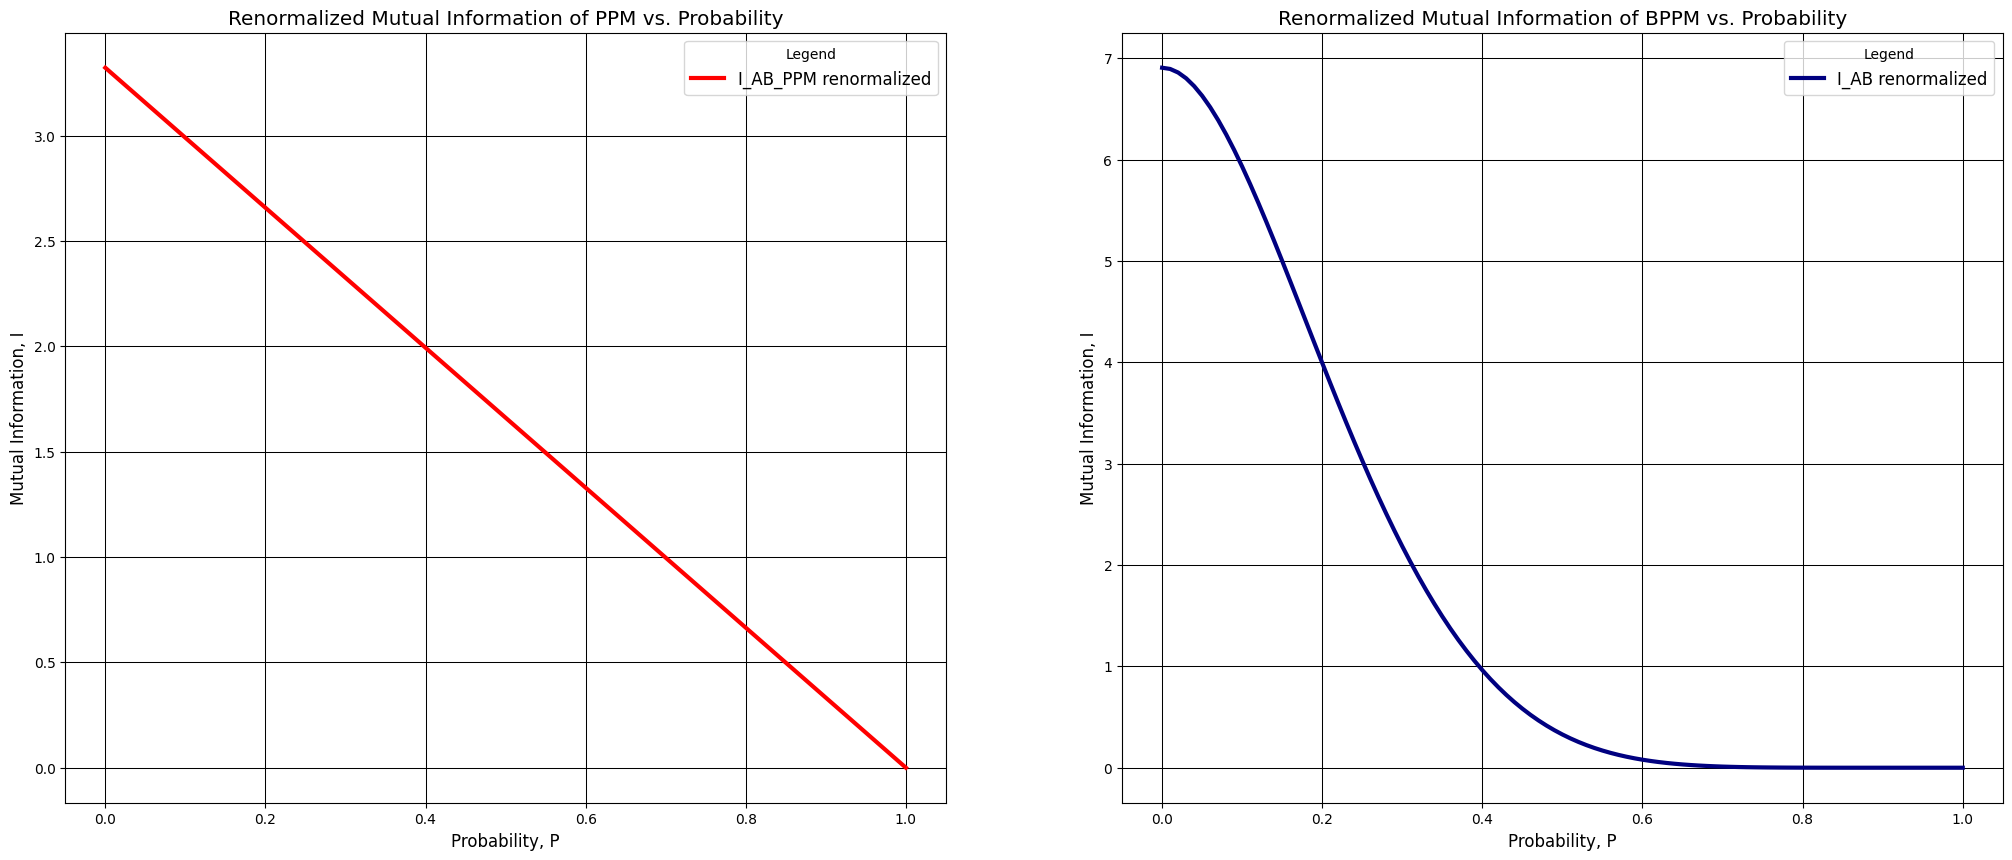

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(25, 10))
P_list = np.linspace(1e-6,0.999999,101)

# plot on the left
axs[0].plot(P_list, I_AB_PPM_list, label='I_AB_PPM renormalized', linewidth=3, color='r', alpha=1)
axs[0].legend(title='Legend', loc='upper right', fontsize='large')
axs[0].grid(color='k', linestyle='-', linewidth=0.75)
axs[0].set_xlabel('Probability, P', fontsize='large')
axs[0].set_ylabel('Mutual Information, I', fontsize='large')
axs[0].set_title('Renormalized Mutual Information of PPM vs. Probability', fontsize='x-large')
axs[0].set_facecolor('white')

# plot on the right
axs[1].plot(P_list, I_AB_list, label='I_AB renormalized', linewidth=3, color='navy', alpha=1)
axs[1].legend(title='Legend', loc='upper right', fontsize='large')
axs[1].grid(color='k', linestyle='-', linewidth=0.75)
axs[1].set_xlabel('Probability, P', fontsize='large')
axs[1].set_ylabel('Mutual Information, I', fontsize='large')
axs[1].set_title('Renormalized Mutual Information of BPPM vs. Probability', fontsize='x-large')
axs[1].set_facecolor('white')

plt.show()

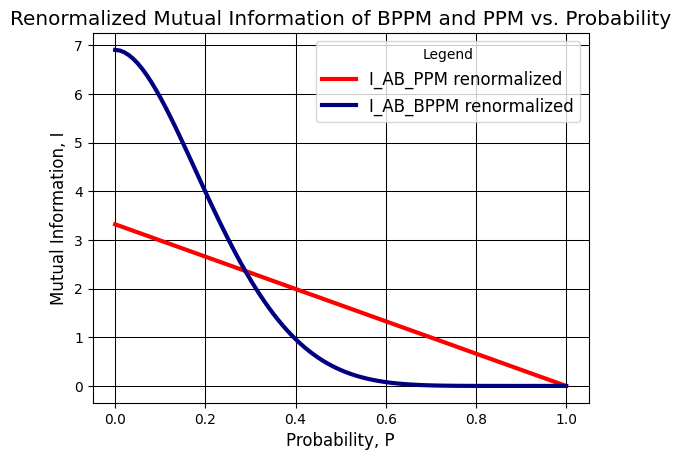

<Figure size 1500x480 with 0 Axes>

In [42]:
# fig, axs = plt.subplots(1, 2, figsize=(25, 10))
P_list = np.linspace(1e-6,0.999999,101)

# plot on the left
plt.plot(P_list, I_AB_PPM_list, label='I_AB_PPM renormalized', linewidth=3, color='r', alpha=1)
plt.plot(P_list, I_AB_list, label='I_AB_BPPM renormalized', linewidth=3, color='navy', alpha=1)

plt.legend(title='Legend', loc='upper right', fontsize='large')
plt.grid(color='k', linestyle='-', linewidth=0.75)
plt.xlabel('Probability, P', fontsize='large')
plt.ylabel('Mutual Information, I', fontsize='large')
plt.title('Renormalized Mutual Information of BPPM and PPM vs. Probability', fontsize='x-large')
#plt.facecolor('white')

# # plot on the right
# plt.plot(P_list, I_AB_list, label='I_AB renormalized', linewidth=3, color='navy', alpha=1)
# axs[1].legend(title='Legend', loc='upper right', fontsize='large')
# axs[1].grid(color='k', linestyle='-', linewidth=0.75)
# axs[1].set_xlabel('Probability, P', fontsize='large')
# axs[1].set_ylabel('Mutual Information, I', fontsize='large')
# axs[1].set_title('Renormalized Mutual Information of BPPM vs. Probability', fontsize='x-large')
# axs[1].set_facecolor('white')
#plt.figure(figsize=(10, 10))
plt.figure().set_figwidth(15)
plt.show()

In [35]:
M

5

In [36]:
# P_D(1,P, 0, l=0,a=0)
# P_Success1(1,P,P,0,0)
combination(5 - 1, 0) * (P)**0 * (1 - P)**(5 - 1 - 0)
combination(1, 0) * (P)**0 * (1 - P)**(1 - 0)
len(P_AB_PPM(5, P_D_val))

10

In [37]:
print(len(I_AB_PPM_list), len(I_AB_PPM_list))

101 101


In [38]:
def compute_T_OOK(n_OOK):
  # def agen(): # generator of terms
  #     aset, sset, k = set(), set(), 0
  #     while True:
  #         k += 1
  #         while any(k+an in sset for an in aset): k += 1
  #         yield k; sset.update(k+an for an in aset); aset.add(k)
  # a = list(islice(agen(), 100))
  # photon = list(map(lambda v: v-1, a))
  # compute_N= [sum(photon[:i]) for i in range(1,len(photon)+1)]
  T_OOK = 2 * n_OOK # int(len(list(itertools.permutations(range(n)))))
  return T_OOK

#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
def combination_OOK(n_OOK, r):
    # if r > n:
    #     return 0
    # else:
    return math.factorial((int(n_OOK))) / (math.factorial((int(n_OOK-r))) * math.factorial((int(r))))

# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution

def Loss_Distribute_OOK(n_OOK, P_l, l):
    # if P_l == 0:
    #     return 1
    # else:
      return combination(n_OOK, l) * (P_l)**l * (1 - P_l)**(n_OOK - l)

def Add_Distribute_OOK(n_OOK, P_a, a):
    T_OOK = compute_T_OOK(n_OOK)
    # if P_a == 0:
    #     return 1
    # else:
    return combination(T_OOK - n, a) * (P_a)**a * (1 - P_a)**(T_OOK - n_OOK - a)

# define a separate function for computing the probability of error
def P_err(n_OOK, P_l, P_a,l,a):
  return Loss_Distribute(n_OOK,P_l,l) * Add_Distribute(n_OOK,P_a, a)
  #return combination(n,l) * (P_l)**l*(1-P_l)**(n-l) * combination(N-n,a) * (P_a)**a*(1-P_a)**(N-n-a) 

def P_Success_OOK(n_OOK,P_l,P_a,l,a):
  return P_err(n_OOK,P_l, P_a, l=0, a=0) 

# Perr[l = 0, a = 0, n = 1, N = M, Ploss, Padd] from mathematica

def P_D_OOK(n_OOK,P_l,P_a, l=0,a=0):
  return 1 - P_Success_OOK(n_OOK,P_l,P_a, l=0, a=0)

def P_AB_OOK(n_OOK, P_D_OOK):
    T_OOK =  compute_T_OOK(n_OOK) #int(len(list(itertools.permutations(range(n)))))
    # P_AB_OOK = [(P ** i) * ((1 - P) ** (n - 1 - i)) for i in range(n)]
    # P_AB_OOK = [(1-P_D_OOK) for i in range(M)]
    matrix = np.eye(T_OOK) * 1/T_OOK  #[[1/M * P_AB_[i] if i == j else 0 for j in range(M)] for i in range(M)]
    return matrix 

def P_A_OOK(P_AB_OOK, P_D_OOK):
    if P_D == 1:
        return [1 for row in P_AB_OOK]
    else:
        return [sum(row) for row in P_AB_OOK] # 1/(1-P_D_OOK)*

# sum over the elements in columns in the probability matrix P_AB
def P_B_OOK(P_AB_OOK, P_D_OOK):
    if P_D == 1:
        return [1 for col in zip(*P_AB_OOK)]
    else:
        return [sum(col) for col in zip(*P_AB_OOK)]
def H_A_OOK(P_AB_OOK):
     P_A_OOK = np.sum(P_AB_OOK, axis=1)
     H_a_OOK = np.sum(-P_A_OOK * np.log2(np.where(P_A_OOK == 0, 1, P_A_OOK)))
     return H_a_OOK

def H_B_OOK(P_AB_OOK):
     P_B_OOK = np.sum(P_AB_OOK, axis=0)
     H_b_OOK = np.sum(-P_B_OOK * np.log2(np.where(P_B_OOK == 0, 1, P_B_OOK)))
     return H_b_OOK

def H_AB_OOK(P_AB_OOK):
    P_AB_OOK = np.where(P_AB_OOK == 0, 1e-9, P_AB_OOK)  # replace zero values with 1e-9
    H_OOK = -(P_AB_OOK * np.log2(P_AB_OOK)).sum()
    return H_OOK

def I_AB_OOK(H_A_OOK, H_B_OOK, H_AB_OOK, P_D_OOK):
    if np.isnan(H_AB_OOK):
        return 0
    else:
        return ((H_A_OOK + H_B_OOK - H_AB_OOK)) * (1-P_D_OOK)

I_AB_OOK_list = []

P_list = np.linspace(1e-6,0.999999,101)

for P in P_list:
  n_OOK = 23
  #N_n = compute_N(n) 
  T_OOK = compute_T_OOK(n_OOK)

  P_D_OOK_val = P_D_OOK(n,P, 0, l=0,a=0)   

  P_AB_OOK_val = P_AB_OOK(M, P_D_OOK_val) # P_AB_OOK(n, P)
  P_AB_OOK_val = np.array(P_AB_OOK_val) # convert list of lists to numpy array
  P_AB_OOK_val = np.where(P_AB_OOK_val <= 0, 1e-9, P_AB_OOK_val)

  H_A_OOK_val = H_A_OOK(P_AB_OOK_val)
  H_B_OOK_val = H_B_OOK(P_AB_OOK_val)
  H_AB_OOK_val = H_AB_OOK(P_AB_OOK_val)

  I_AB_OOK_val = I_AB_OOK(H_A_OOK_val, H_B_OOK_val, H_AB_OOK_val, P_D_OOK_val)
  I_AB_OOK_list.append(I_AB_OOK_val)

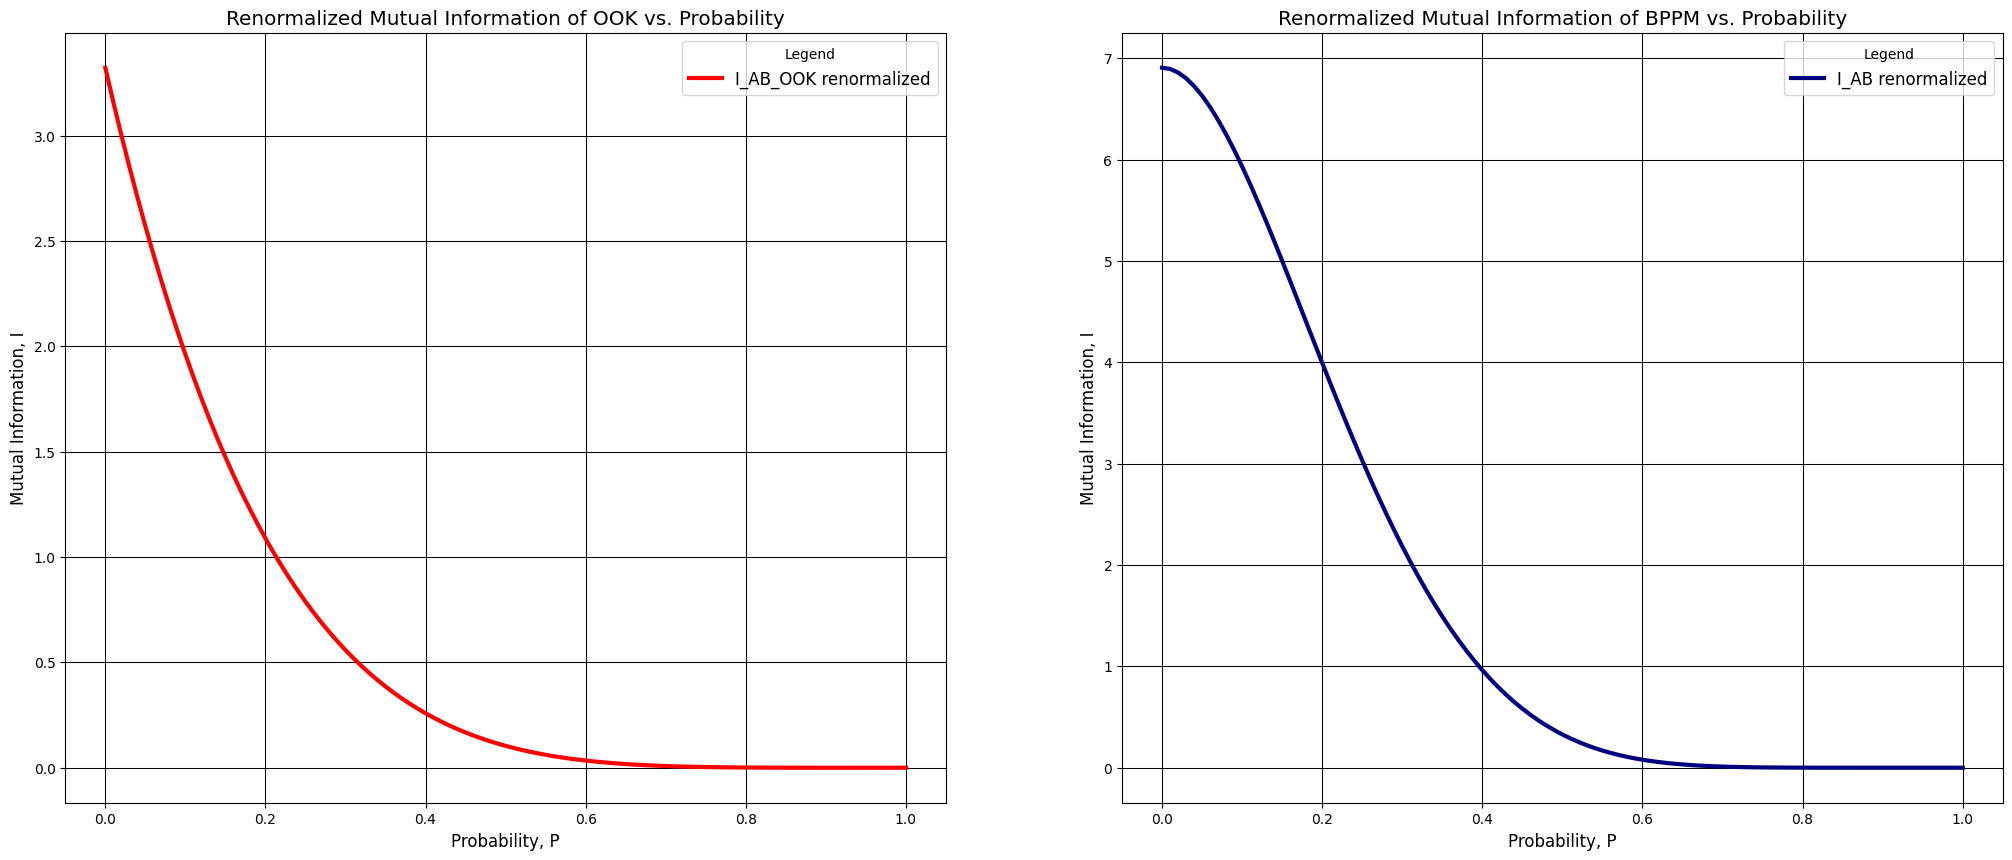

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(25, 10))
P_list = np.linspace(1e-6,0.999999,101)

# plot on the left
axs[0].plot(P_list, I_AB_OOK_list, label='I_AB_OOK renormalized', linewidth=3, color='r', alpha=1)
axs[0].legend(title='Legend', loc='upper right', fontsize='large')
axs[0].grid(color='k', linestyle='-', linewidth=0.75)
axs[0].set_xlabel('Probability, P', fontsize='large')
axs[0].set_ylabel('Mutual Information, I', fontsize='large')
axs[0].set_title('Renormalized Mutual Information of OOK vs. Probability', fontsize='x-large')
axs[0].set_facecolor('white')

# plot on the right
axs[1].plot(P_list, I_AB_list, label='I_AB renormalized', linewidth=3, color='navy', alpha=1)
axs[1].legend(title='Legend', loc='upper right', fontsize='large')
axs[1].grid(color='k', linestyle='-', linewidth=0.75)
axs[1].set_xlabel('Probability, P', fontsize='large')
axs[1].set_ylabel('Mutual Information, I', fontsize='large')
axs[1].set_title('Renormalized Mutual Information of BPPM vs. Probability', fontsize='x-large')
axs[1].set_facecolor('white')

plt.show()

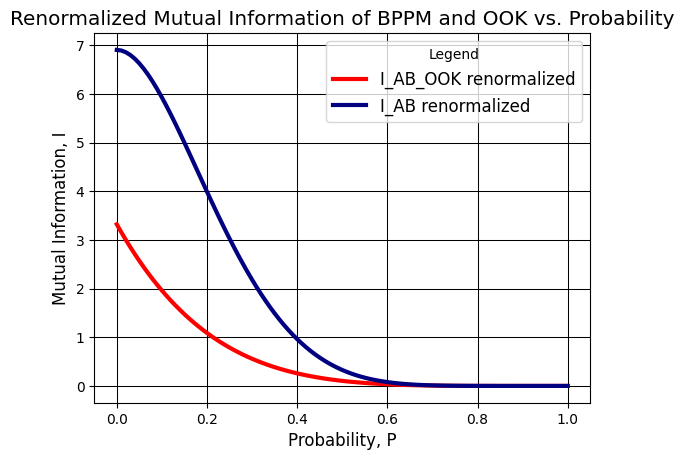

<Figure size 1500x480 with 0 Axes>

In [40]:
# fig, axs = plt.subplots(1, 2, figsize=(25, 10))
P_list = np.linspace(1e-6,0.999999,101)

# plot on the left
plt.plot(P_list, I_AB_OOK_list, label='I_AB_OOK renormalized', linewidth=3, color='r', alpha=1)
plt.plot(P_list, I_AB_list, label='I_AB renormalized', linewidth=3, color='navy', alpha=1)

plt.legend(title='Legend', loc='upper right', fontsize='large')
plt.grid(color='k', linestyle='-', linewidth=0.75)
plt.xlabel('Probability, P', fontsize='large')
plt.ylabel('Mutual Information, I', fontsize='large')
plt.title('Renormalized Mutual Information of BPPM and OOK vs. Probability', fontsize='x-large')
#plt.facecolor('white')

# # plot on the right
# plt.plot(P_list, I_AB_list, label='I_AB renormalized', linewidth=3, color='navy', alpha=1)
# axs[1].legend(title='Legend', loc='upper right', fontsize='large')
# axs[1].grid(color='k', linestyle='-', linewidth=0.75)
# axs[1].set_xlabel('Probability, P', fontsize='large')
# axs[1].set_ylabel('Mutual Information, I', fontsize='large')
# axs[1].set_title('Renormalized Mutual Information of BPPM vs. Probability', fontsize='x-large')
# axs[1].set_facecolor('white')
#plt.figure(figsize=(10, 10))
plt.figure().set_figwidth(15)
plt.show()

# General

The number of symbols m in general method will be the number of ways k photons can be placed in n bins, i.e. 

$$m= \binom{n}{k}$$

If we have 4 photons, 14 timeslots, then there will be 1,0001 ways to order them by binomial where order does not matter.

The number of bits (the information content per symbol) will be 
$$b=log_2m$$

However, if we consider the repeition are not allowed, then we use 
Permutations = r! x Combinations 

B1. Compare with "general" method using same number of slots, n, and same number of photons, k \\

B2. The number of symbols m in general method will be the number ow ways k photons can be placed in n bins, i.e. m=(n over k) \\

B3. The number of bits (the information content per symbol) will be b=log2(m)


We can use $\binom{10}{2}$ and $\binom{15}{3}$ to maintain the power $\frac{1}{5}$ for comparison

In [58]:
def compute_T_General(n_General):
  # def agen(): # generator of terms
  #     aset, sset, k = set(), set(), 0
  #     while True:
  #         k += 1
  #         while any(k+an in sset for an in aset): k += 1
  #         yield k; sset.update(k+an for an in aset); aset.add(k)
  # a = list(islice(agen(), 100))
  # photon = list(map(lambda v: v-1, a))
  # compute_N= [sum(photon[:i]) for i in range(1,len(photon)+1)]
  T_General = 5 * n_General # int(len(list(itertools.permutations(range(n)))))
  return T_General

#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
def combination_General(T_General, n_General):
    # if r > n:
    #     return 0
    # else:
    return math.factorial((int(T_General))) / (math.factorial((int(T_General-n_General))) * math.factorial((int(n_General))))

# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution

def Loss_Distribute_General(n_General, P_l, l):
    # if P_l == 0:
    #     return 1
    # else:
      return combination(n_General, l) * (P_l)**l * (1 - P_l)**(n_General - l)

def Add_Distribute_General(n_General, P_a, a):
    T_General = compute_T_General(n_General)
    # if P_a == 0:
    #     return 1
    # else:
    return combination(T_General - n, a) * (P_a)**a * (1 - P_a)**(T_General - n_General - a)

# define a separate function for computing the probability of error
def P_err(n_General, P_l, P_a,l,a):
  return Loss_Distribute(n_General,P_l,l) * Add_Distribute(n_General,P_a, a)

def P_Success_General(n_General,P_l,P_a,l,a):
  return P_err(n_General,P_l, P_a, l=0, a=0) 

# Perr[l = 0, a = 0, n = 1, N = M, Ploss, Padd] from mathematica

def P_D_General(n_General,P_l,P_a, l=0,a=0):
  return 1 - P_Success_General(n_General,P_l,P_a, l=0, a=0)

def P_AB_General(n_General):
    T_General =  compute_T_General(n_General)
    matrix = np.eye(int(combination(T_General, n_General))) / combination(T_General, n_General)  
    return matrix 

def P_A_General(P_AB_General, P_D_General):
    if P_D == 1:
        return [1 for row in P_AB_General]
    else:
        return [sum(row) for row in P_AB_General] # 1/(1-P_D_OOK)*

# sum over the elements in columns in the probability matrix P_AB
def P_B_General(P_AB_General, P_D_General):
    if P_D == 1:
        return [1 for col in zip(*P_AB_General)]
    else:
        return [sum(col) for col in zip(*P_AB_General)]
    
def H_A_General(P_AB_General):
     P_A_General = np.sum(P_AB_General, axis=1)
     H_a_General = np.sum(-P_A_General * np.log2(np.where(P_A_General == 0, 1, P_A_General)))
     return H_a_General

def H_B_General(P_AB_General):
     P_B_General = np.sum(P_AB_General, axis=0)
     H_b_General = np.sum(-P_B_General * np.log2(np.where(P_B_General == 0, 1, P_B_General)))
     return H_b_General

def H_AB_General(P_AB_General):
    P_AB_General = np.where(P_AB_General == 0, 1e-9, P_AB_General)  # replace zero values with 1e-9
    H_General = -(P_AB_General * np.log2(P_AB_General)).sum()
    return H_General

def I_AB_General(H_A_General, H_B_General, H_AB_General, P_D_General):
    if np.isnan(H_AB_General):
        return 0
    else:
        return ((H_A_General + H_B_General - H_AB_General)) * (1-P_D_General)

I_AB_General_list = []

P_list = np.linspace(1e-6,0.999999,101)

for P in P_list:
  n_General = 2
  T_General = compute_T_General(n_General)

  P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

  P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
  P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
  P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

  H_A_General_val = H_A_General(P_AB_General_val)
  H_B_General_val = H_B_General(P_AB_General_val)
  H_AB_General_val = H_AB_General(P_AB_General_val)

  I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)
  I_AB_General_list.append(I_AB_General_val)

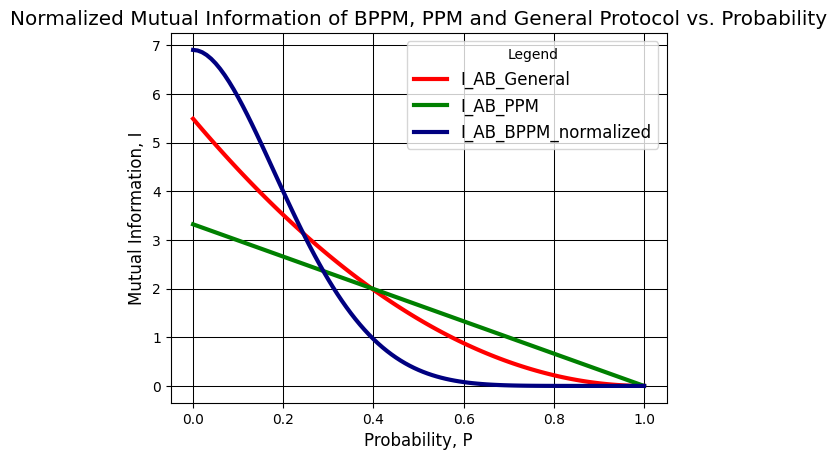

<Figure size 1500x480 with 0 Axes>

In [59]:
# fig, axs = plt.subplots(1, 2, figsize=(25, 10))
P_list = np.linspace(1e-6,0.999999,101)

# plot on the left
plt.plot(P_list, I_AB_General_list, label='I_AB_General', linewidth=3, color='r', alpha=1)
plt.plot(P_list, I_AB_PPM_list, label='I_AB_PPM', linewidth=3, color='g', alpha=1)
plt.plot(P_list, I_AB_list, label='I_AB_BPPM_normalized', linewidth=3, color='navy', alpha=1)

plt.legend(title='Legend', loc='upper right', fontsize='large')
plt.grid(color='k', linestyle='-', linewidth=0.75)
plt.xlabel('Probability, P', fontsize='large')
plt.ylabel('Mutual Information, I', fontsize='large')
plt.title('Normalized Mutual Information of BPPM, PPM and General Protocol vs. Probability', fontsize='x-large')
#plt.facecolor('white')

# # plot on the right
# plt.plot(P_list, I_AB_list, label='I_AB renormalized', linewidth=3, color='navy', alpha=1)
# axs[1].legend(title='Legend', loc='upper right', fontsize='large')
# axs[1].grid(color='k', linestyle='-', linewidth=0.75)
# axs[1].set_xlabel('Probability, P', fontsize='large')
# axs[1].set_ylabel('Mutual Information, I', fontsize='large')
# axs[1].set_title('Renormalized Mutual Information of BPPM vs. Probability', fontsize='x-large')
# axs[1].set_facecolor('white')
#plt.figure(figsize=(10, 10))
plt.figure().set_figwidth(15)
plt.show()

In [60]:
combination(T_General, n_General)

45.0

In [48]:
P_AB_General(n_General), len(P_AB_General(n_General))

(array([[0.2, 0. , 0. , 0. , 0. ],
        [0. , 0.2, 0. , 0. , 0. ],
        [0. , 0. , 0.2, 0. , 0. ],
        [0. , 0. , 0. , 0.2, 0. ],
        [0. , 0. , 0. , 0. , 0.2]]),
 5)

In [ ]:
P_AB_General_val = P_AB_General(n_General)
# P_AB_General_val = np.array(P_AB_General_val)
# P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

In [ ]:
H_A_General_val = H_A_General(P_AB_General_val)

# OOK

It will in average use k=n/2 photons per symbol
 OOKWays = (2)**series[n-1]    number of symbols m in PPM will be m=2^n
 OOKbps = math.log2(OOKWays)   The number of bits (the information content per symbol) will be b=log2(m)=n
 OOKbpp = 2 # bit per photon
 OOKbpt = 1 # bit per time bin
